# 🚢 Titanic Survival Prediction  

This project is based on the Kaggle **Titanic: Machine Learning from Disaster** challenge.  
The goal is to build a model that predicts whether a passenger survived the Titanic shipwreck, using features such as **Age, Sex, Passenger Class, and Family Size**.  

### 🔎 Key Highlights
- Data preprocessing and handling missing values (`Age`, `Embarked`, `Cabin`).  
- Encoding categorical variables (`Sex`, `Embarked`, `Pclass`).  
- Exploratory Data Analysis (EDA) to find survival patterns.  
- Training a **Logistic Regression classifier**.  
- Evaluating the model using accuracy, confusion matrix, and classification report.  

### 🎯 Objective
To develop a baseline machine learning pipeline that can generalize well and predict passenger survival with high accuracy.


## loading the data 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 


df=pd.read_csv('titanic/train.csv' )

df=df.drop("PassengerId", axis=1 )

df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## data preprocessing and analysis 

In [2]:
## data preprocessing stage 

## encoding of categorical features 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Select categorical features
cat_features = ["Sex", "Embarked", "Pclass"]
sex_feature=df["Sex"]
Embarked_feature=df["Embarked"]
Pclass_feature=df["Pclass"]
# One-hot encoding
nominal_dummies = pd.get_dummies(df[cat_features], drop_first=True)
df = pd.concat([df, nominal_dummies], axis=1)
df.drop(cat_features, axis=1, inplace=True)

# Handle missing values
for col in df.columns:
    perc_of_nulls = df[col].isnull().mean()
    if perc_of_nulls > 0.75:
        df.drop(col, axis=1, inplace=True)
    else:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].mean())

# Remove duplicate values
df = df.drop_duplicates()

# Scale Fare
scaler = MinMaxScaler()
df["Fare"] = scaler.fit_transform(df[["Fare"]])
df["Age"]=scaler.fit_transform(df[["Age"]])


df.head(3)


,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,"Braund, Mr. Owen Harris",0.271174,1,0,A/5 21171,0.014151,True,False,True
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.472229,1,0,PC 17599,0.139136,False,False,False
2,1,"Heikkinen, Miss. Laina",0.321438,0,0,STON/O2. 3101282,0.015469,False,False,True


In [3]:
# the preprocessing of Name and ticket will take another process 
## the name is unique so we can not use one hot encoding to encode these features 
## so we will make use of the title in the name only
import re

# Extract title using regex
df["Title"] = df["Name"].apply(lambda x: re.search(r",\s*([^\.]+)\.", x).group(1))
title=df["Title"]
# Now replace rare titles with "Rare"
df["Title"] = df["Title"].replace(
    ["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", 
     "Sir", "Jonkheer", "Dona"], "Rare"
)

# Drop original Name column since it's not useful
df.drop("Name", axis=1, inplace=True)

# Now you can encode Title instead of Name
df = pd.get_dummies(df, columns=["Title"], drop_first=True)


df.head(3)





,Survived,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rare,Title_the Countess
0,0,0.271174,1,0,A/5 21171,0.014151,True,False,True,False,False,False,True,False,False,False,False
1,1,0.472229,1,0,PC 17599,0.139136,False,False,False,False,False,False,False,True,False,False,False
2,1,0.321438,0,0,STON/O2. 3101282,0.015469,False,False,True,True,False,False,False,False,False,False,False


In [4]:
## we will extract the ticket prefix of the letter 
# Extract ticket prefix (letters only)
df["TicketPrefix"] = df["Ticket"].str.extract(r'([A-Za-z]+)', expand=False).fillna("None")
ticketPrefix=df["TicketPrefix"]
# Encode TicketPrefix
df = pd.get_dummies(df, columns=["TicketPrefix"], drop_first=True)

# Drop the original Ticket column
df.drop("Ticket", axis=1, inplace=True)
df.head(3)


,Survived,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mlle,...,TicketPrefix_PP,TicketPrefix_S,TicketPrefix_SC,TicketPrefix_SCO,TicketPrefix_SO,TicketPrefix_SOTON,TicketPrefix_STON,TicketPrefix_SW,TicketPrefix_W,TicketPrefix_WE
0,0,0.271174,1,0,0.014151,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0.472229,1,0,0.139136,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,0.321438,0,0,0.015469,False,False,True,True,False,...,False,False,False,False,False,False,True,False,False,False


In [5]:
## splitting the data into train test split 
from sklearn.model_selection import train_test_split 
X=df.drop("Embarked_S" , axis=1)
Y=df["Survived"]
x_train,x_test,y_train,y_test=train_test_split(X,Y , test_size=0.2)

x_train.shape


(712, 33)

In [18]:
## data analysis step 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Survived            891 non-null    int64  
 1   Age                 891 non-null    float64
 2   SibSp               891 non-null    int64  
 3   Parch               891 non-null    int64  
 4   Fare                891 non-null    float64
 5   Sex_male            891 non-null    bool   
 6   Embarked_Q          891 non-null    bool   
 7   Embarked_S          891 non-null    bool   
 8   Title_Miss          891 non-null    bool   
 9   Title_Mlle          891 non-null    bool   
 10  Title_Mme           891 non-null    bool   
 11  Title_Mr            891 non-null    bool   
 12  Title_Mrs           891 non-null    bool   
 13  Title_Ms            891 non-null    bool   
 14  Title_Rare          891 non-null    bool   
 15  Title_the Countess  891 non-null    bool   
 16  TicketPr

In [19]:
df.describe()

,Survived,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,0.367921,0.523008,0.381594,0.062858
std,0.486592,0.163383,1.102743,0.806057,0.096995
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.271174,0.000000,0.000000,0.015440
50%,0.000000,0.367921,0.000000,0.000000,0.028213
75%,1.000000,0.434531,1.000000,0.000000,0.060508
max,1.000000,1.000000,8.000000,6.000000,1.000000


### 🔹1.analysis of each feature individually 

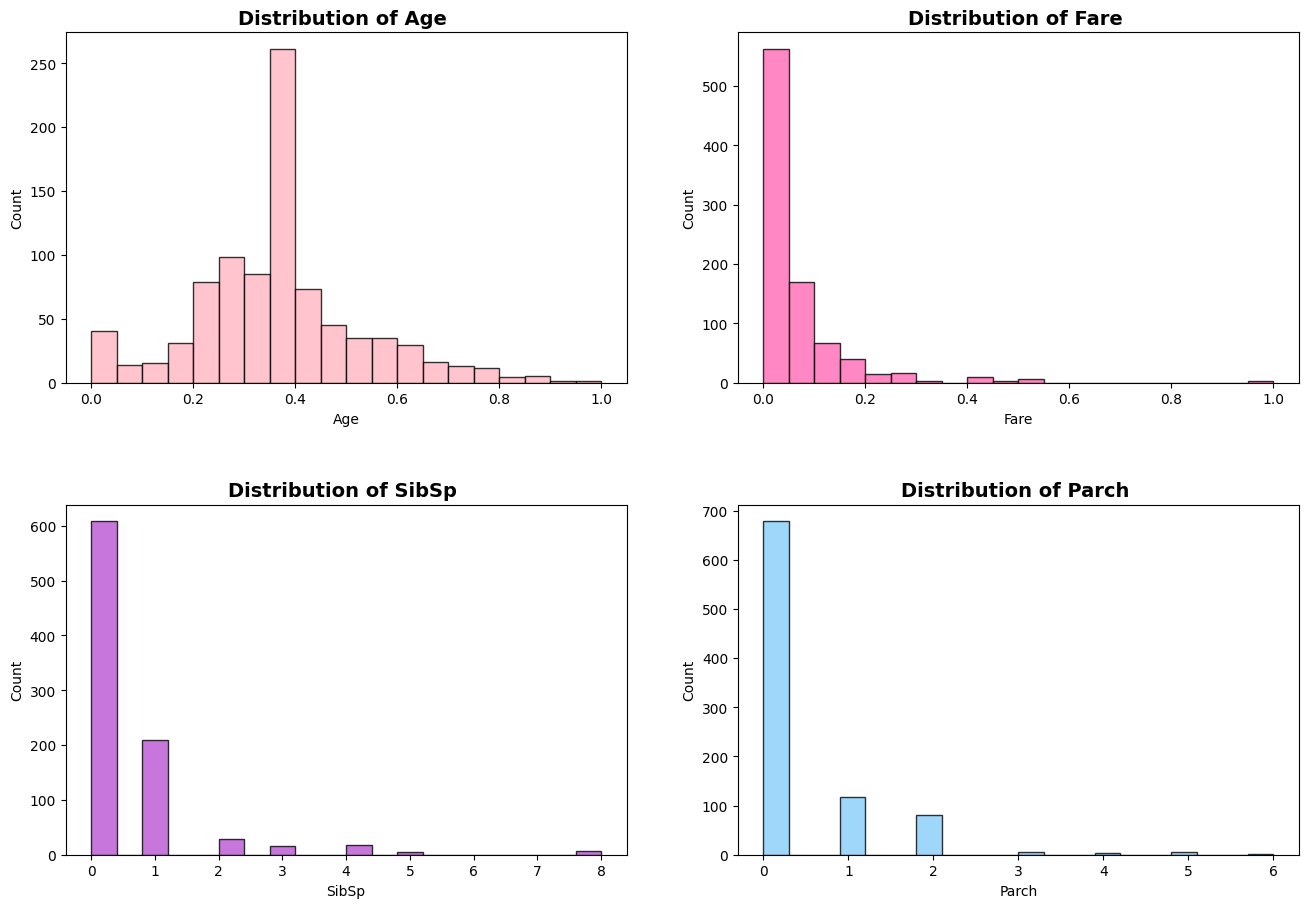

In [48]:
## numerical features 
pastel_colors = ["#FFB6C1", "#FF69B4", "#BA55D3", "#87CEFA"]  
# light pink, hot pink, orchid purple, baby blue

# Select numerical features
num_features = ["Age", "Fare", "SibSp", "Parch"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # flatten for easy iteration

for i, feature in enumerate(num_features):
    axes[i].hist(df[feature].dropna(), bins=20, color=pastel_colors[i], edgecolor="black", alpha=0.8)
    axes[i].set_title(f"Distribution of {feature} ", fontsize=14, fontweight="bold")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")

plt.tight_layout(pad=4)
plt.show()


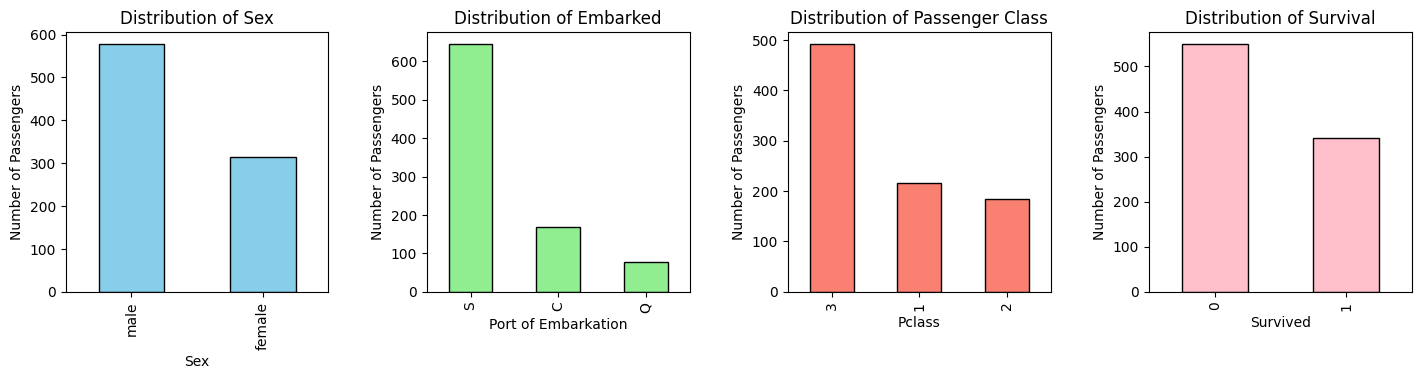

In [10]:
## categorical feature analysis 
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(15, 4))
plt.tight_layout(pad=4)

# Sex distribution
sex_feature.value_counts().plot(kind="bar", ax=axes[0], color="skyblue", edgecolor="black")
axes[0].set_title("Distribution of Sex")
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Number of Passengers")

# Embarked distribution
Embarked_feature.value_counts().plot(kind="bar", ax=axes[1], color="lightgreen", edgecolor="black")
axes[1].set_title("Distribution of Embarked")
axes[1].set_xlabel("Port of Embarkation")
axes[1].set_ylabel("Number of Passengers")

# Pclass distribution
Pclass_feature.value_counts().plot(kind="bar", ax=axes[2], color="salmon", edgecolor="black")
axes[2].set_title("Distribution of Passenger Class")
axes[2].set_xlabel("Pclass")
axes[2].set_ylabel("Number of Passengers")

# Survived distribution
df["Survived"].value_counts().plot(kind="bar", ax=axes[3], color="pink", edgecolor="black")
axes[3].set_title("Distribution of Survival")
axes[3].set_xlabel("Survived")
axes[3].set_ylabel("Number of Passengers")

plt.show()



#### 🔹 2. Bivariate Analysis (each feature with the target class)

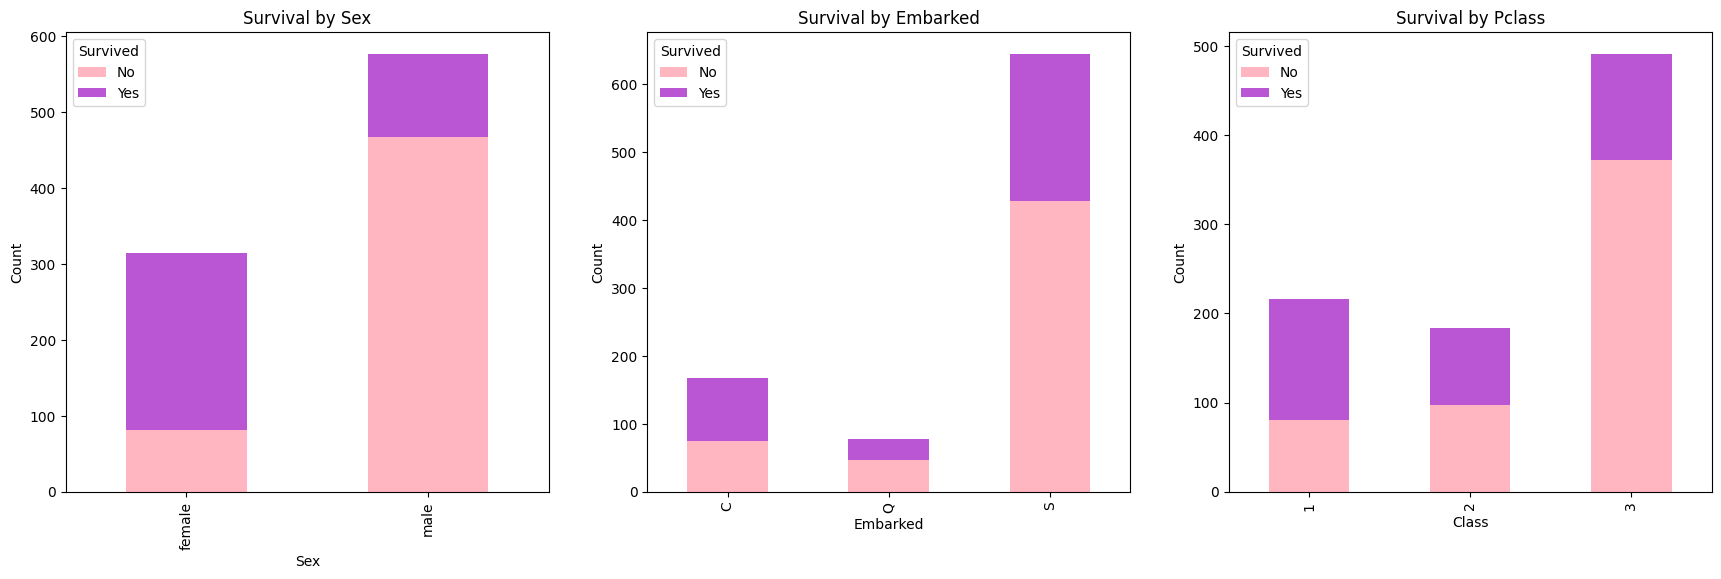

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.tight_layout(pad=4)

# 1. Sex vs Survival
pd.crosstab(sex_feature, df["Survived"]).plot(kind="bar", stacked=True, ax=axes[0], color=["#FFB6C1", "#BA55D3"])
axes[0].set_title("Survival by Sex")
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Count")
axes[0].legend(title="Survived", labels=["No", "Yes"])

# 2. Embarked vs Survival
pd.crosstab(Embarked_feature, df["Survived"]).plot(kind="bar", stacked=True, ax=axes[1], color=["#FFB6C1", "#BA55D3"])
axes[1].set_title("Survival by Embarked")
axes[1].set_xlabel("Embarked")
axes[1].set_ylabel("Count")
axes[1].legend(title="Survived", labels=["No", "Yes"])

# 3. Pclass vs Survival
pd.crosstab(Pclass_feature, df["Survived"]).plot(kind="bar", stacked=True, ax=axes[2], color=["#FFB6C1", "#BA55D3"])
axes[2].set_title("Survival by Pclass")
axes[2].set_xlabel("Class")
axes[2].set_ylabel("Count")
axes[2].legend(title="Survived", labels=["No", "Yes"])

plt.show()


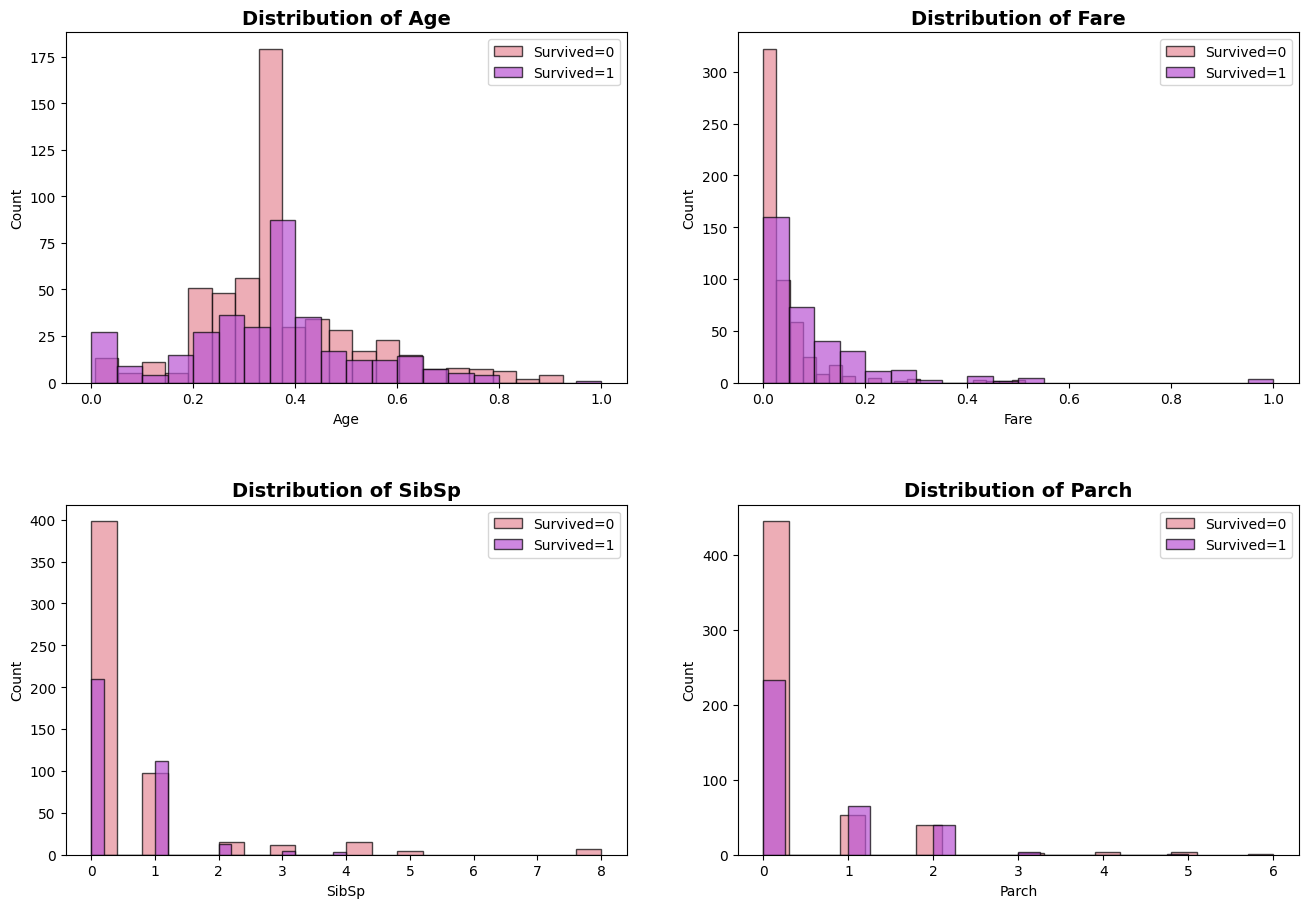

In [50]:
import matplotlib.pyplot as plt

# Define girly pastel palette 
pastel_colors = {0: "#E68A97", 1: "#BA55D3"}  
# 0 = not survived (light pink), 1 = survived (orchid purple)

# Numerical features to analyze
num_features = ["Age", "Fare", "SibSp", "Parch"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    for target in [0, 1]:
        axes[i].hist(
            df[df["Survived"] == target][feature].dropna(),
            bins=20,
            alpha=0.7,
            label=f"Survived={target}",
            color=pastel_colors[target],
            edgecolor="black"
        )
    
    axes[i].set_title(f"Distribution of {feature}", fontsize=14, fontweight="bold")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")
    axes[i].legend()

plt.tight_layout(pad=4)
plt.show()


## 💎 model selection and evaluation 

In [6]:
## logistic regression model 
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()

lr.fit(x_train, y_train)
lr

LogisticRegression()

In [7]:
## predicting the labels 
from sklearn.metrics import classification_report

y_predicted=lr.predict(x_test)
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00        70

    accuracy                           1.00       179
   macro avg       1.00      1.00      1.00       179
weighted avg       1.00      1.00      1.00       179

